# Compare predictions
This notebook includes a comparison between the predictions of the hydroestimator, the cnn and the mlp on the rain gauge data.

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
from matplotlib import cm
import copy
import torch
import xarray as xr
import pandas as pd
import os
import datetime

import cartopy
import cartopy.crs as ccrs
from pyresample import load_area, geometry

import quantnn

In [82]:
plt.style.use('seaborn-whitegrid')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [83]:
SMALL_SIZE = 16 #8
MEDIUM_SIZE = 18 #10
BIGGER_SIZE = 20 #12
matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [84]:
#colors
color_HE_corr = '#ec6726'
color_HE ='#d1b126'
color_cnn ='#72196d'
color_mlp = '#327a4f'
color_gauges = '#64a6a1'
color_neutral = '#990909'
color_grid = "#e9e9e9"

#alpha
alpha_HE_corr_hist = 0.4
alpha_gauges_hist = 0.3

In [523]:
#figure size
figsize_single_plot = (9,6)
figsize_two_cols = (13,6)
figsize_four = (13,10)

In [524]:
#data path
f = open('../path_to_data.txt', "r")
path_to_dataset = os.path.join(f.readline().rstrip("\n"))
f.close() 

In [525]:
#load dataset
combined_all = xr.open_dataset(os.path.join(path_to_dataset,'combined.nc'))

In [526]:
combined_all

<xarray.Dataset>
Dimensions:                  (location: 609, time: 738)
Coordinates:
  * location                 (location) int64 0 1 2 3 4 ... 604 605 606 607 608
  * time                     (time) datetime64[ns] 2020-12-01T01:00:00 ... 20...
Data variables:
    xception_posterior_mean  (time, location) float32 ...
    xception_Q0.95           (time, location) float32 ...
    xception_Q0.99           (time, location) float32 ...
    mlp_posterior_mean       (time, location) float32 ...
    mlp_Q0.95                (time, location) float32 ...
    mlp_Q0.99                (time, location) float32 ...
    HE_precip                (time, location) float64 ...
    HE_precip_corr           (time, location) float64 ...
    gauge_precip             (time, location) float64 ...

### Metadata

In [527]:
#load metadata
metadata = pd.read_pickle(os.path.join(path_to_dataset, 'real_rain_gauge_data', 'general_rain_gauge_info.pckl'))

In [528]:
#metadata[(metadata.lon< -43.2) & (metadata.lat< 22.5) & (metadata.state=='RJ')] #429

### NaNs

In [529]:
print('NaNs in gauges:', np.isnan(combined_all.gauge_precip.values).sum())
print('NaNs in HE:', np.isnan(combined_all.HE_precip.values).sum())
print('NaNs in HE corr:', np.isnan(combined_all.HE_precip_corr.values).sum())
print('NaNs in MLP:', np.isnan(combined_all.mlp_posterior_mean.values).sum())
print('NaNs in CNN:', np.isnan(combined_all.xception_posterior_mean.values).sum())

NaNs in gauges: 165555
NaNs in HE: 6090
NaNs in HE corr: 6090
NaNs in MLP: 1759
NaNs in CNN: 1759


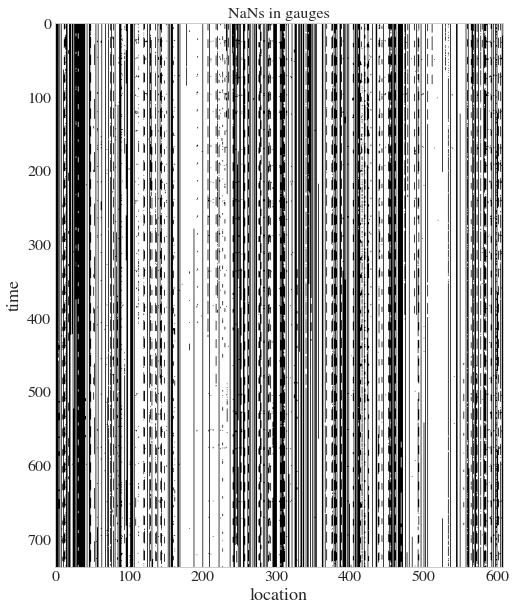

In [530]:
fig, ax = plt.subplots(figsize=(10,10))
data = combined_all.gauge_precip.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
ax.imshow(m, cmap='binary')
ax.set_xlabel('location')
ax.set_ylabel('time')
ax.set_title('NaNs in gauges')
ax.grid(False)
plt.show()

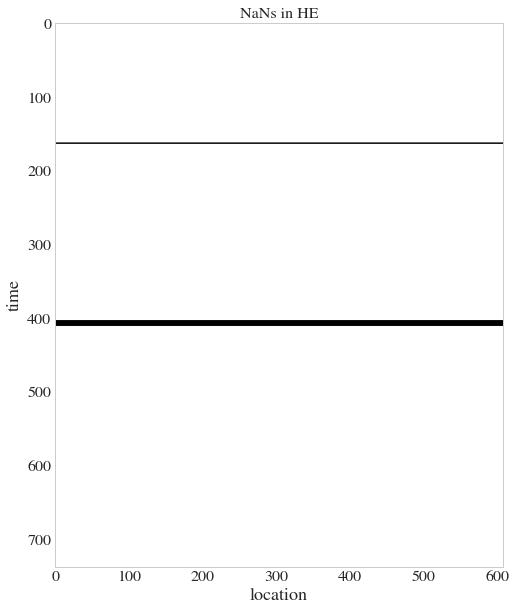

In [531]:
fig, ax = plt.subplots(figsize=(10,10))
data = combined_all.HE_precip.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
ax.imshow(m, cmap='binary')
ax.set_xlabel('location')
ax.set_ylabel('time')
ax.set_title('NaNs in HE')
ax.grid(False)
plt.show()

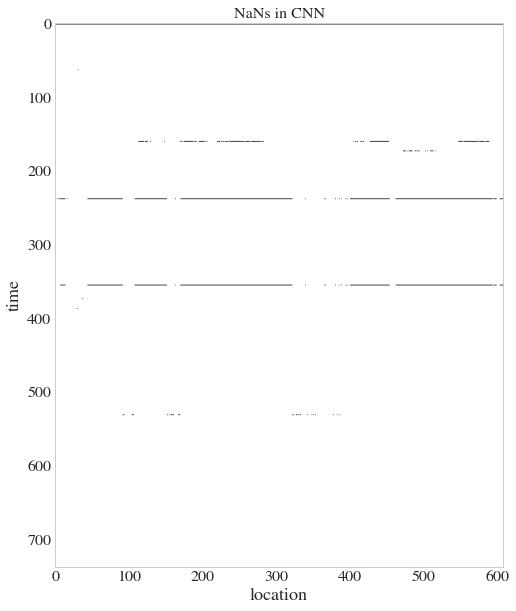

In [532]:
fig, ax = plt.subplots(figsize=(10,10))
data = combined_all.xception_posterior_mean.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
ax.imshow(m, cmap='binary')
ax.set_xlabel('location')
ax.set_ylabel('time')
ax.set_title('NaNs in CNN')
ax.grid(False)
plt.show()

In [533]:
mask = np.zeros((combined_all.gauge_precip.values.shape[0], combined_all.gauge_precip.values.shape[1]))
mask[np.isnan(combined_all.gauge_precip.values)] = 1
mask[np.isnan(combined_all.HE_precip.values)] = 1
mask[np.isnan(combined_all.xception_posterior_mean.values)] = 1
print(mask)
print('missing values fraction:', mask.sum()/len(mask.flatten()))

[[0. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 0. 0.]
 ...
 [0. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]]
missing values fraction: 0.3793793192447524


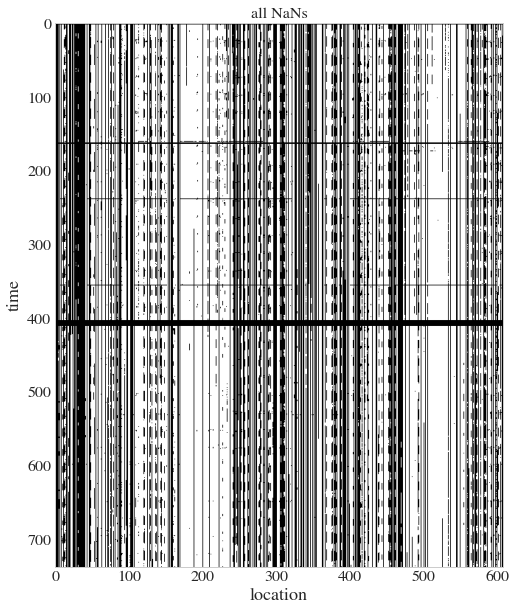

In [534]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(mask, cmap='binary')
ax.set_xlabel('location')
ax.set_ylabel('time')
ax.set_title('all NaNs')
ax.grid(False)
plt.show()

In [535]:
# Make sure that comparison is done only where values are present in all datasets.
combined = combined_all.copy()
combined = combined.where(mask==0)

### Gauges

In [536]:
#Explore properties of reference data
dat = combined.gauge_precip.values[mask==0].flatten()
print('unique values in gauge data:', np.unique(dat))
start = -0.1
end = 83.3
binsize = 0.2
num_of_bins = int(np.round((end-start)/binsize)+1)
bins = np.linspace(start,end,num_of_bins)
print('matching bins:', bins)

unique values in gauge data: [ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6
  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4
  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.
 11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8
 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.  16.2 16.4 16.6
 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8 19.  19.2 19.4
 19.6 19.8 20.  20.2 20.4 20.6 20.8 21.  21.2 21.4 21.6 21.8 22.  22.2
 22.4 22.6 22.8 23.  23.2 23.4 23.6 23.8 24.  24.2 24.4 24.6 24.8 25.
 25.2 25.4 25.6 25.8 26.  26.2 26.4 26.6 26.8 27.  27.2 27.4 27.6 27.8
 28.  28.2 28.4 28.6 28.8 29.  29.2 29.4 29.6 29.8 30.  30.2 30.4 30.6
 30.8 31.  31.4 31.6 32.  32.2 32.4 32.6 33.2 33.6 33.8 34.  34.4 34.6
 34.8 35.  35.2 35.4 35.6 35.8 36.  36.2 36.4 36.6 36.8 37.  37.2 37.6
 38.4 38.6 38.8 39.  39.2 39.6 39.8 40.2 40.4 40.6

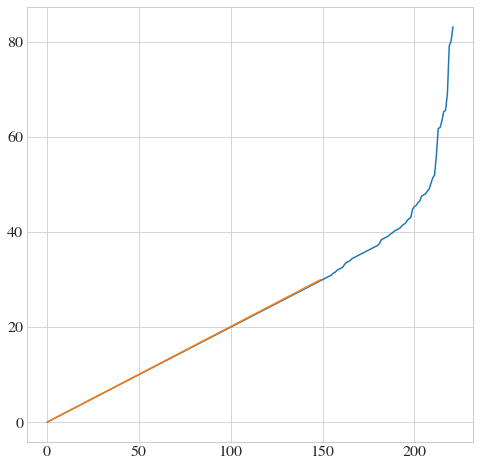

In [537]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(np.unique(dat))
#plt.yscale('log')
ax.plot([0,149], [0,30])

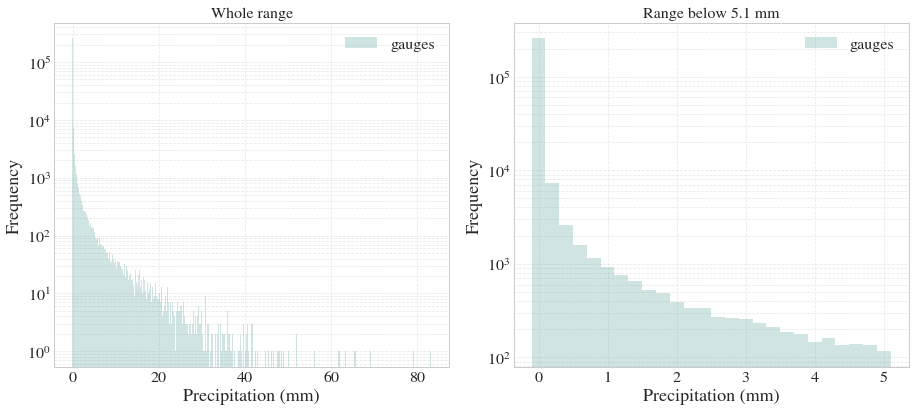

In [538]:

fig, ax = plt.subplots(ncols=2, figsize=figsize_two_cols)

def rangeSubplot(dat, bins, axnum=0, title="Whole range"):
    ax[axnum].hist(dat, bins=bins,  alpha=alpha_gauges_hist, label='gauges',
            color=color_gauges, linewidth=0.0, rasterized=True)
    ax[axnum].set_yscale("log")
    ax[axnum].grid(True,which="both",ls="--",c=color_grid)
    ax[axnum].set_xlabel('Precipitation (mm)')
    ax[axnum].set_ylabel('Frequency')
    ax[axnum].set_title(title)
    ax[axnum].legend()

    
n_sub = 27
rangeSubplot(dat, bins, axnum=0, title="Whole range")
rangeSubplot(dat, bins[:n_sub], axnum=1, title="Range below 5.1 mm")

plt.tight_layout()

### Single rain gauge over time

In [539]:

def plotGaugeTimeseries(ind,start=0,end=-1):
    fig, ax = plt.subplots(figsize=(16,8))
    #plt.plot(combined.time, combined.mlp_posterior_mean[:, ind], label='mlp')
    plt.plot(combined.time[start:end], combined.xception_posterior_mean[start:end, ind], color=color_cnn, linestyle='dashed', label='CNN')
    plt.fill_between(combined.time[start:end], combined['xception_Q0.95'][start:end, ind],alpha=0.07, color=color_cnn)
    plt.fill_between(combined.time[start:end], combined['xception_Q0.99'][start:end, ind],alpha=0.1, color=color_cnn)
    #plt.plot(combined.time, combined.HE_precip[:, ind], label='HE')
    plt.plot(combined.time[start:end], combined.HE_precip_corr[start:end, ind], label='corrected HE', linestyle='dashdot', color=color_HE_corr)
    plt.plot(combined.time[start:end], combined.gauge_precip[start:end, ind], label='gauge', color=color_gauges)
    ax.grid(True,which="both",ls="--",c=color_grid)
    ax.set_ylabel('Precipitation (mm)')
    ax.set_xlabel('Datetime (hour)')
    ax.legend()


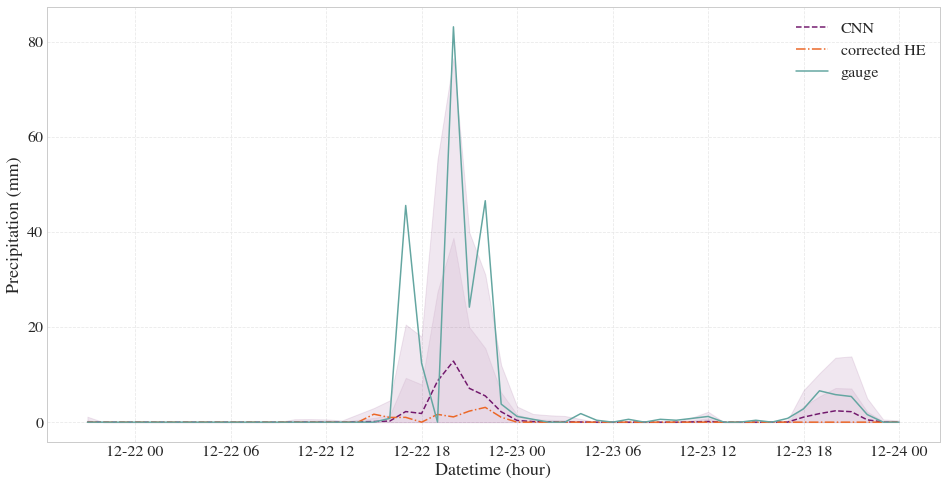

In [540]:
plotGaugeTimeseries(429,500,552) # Xerém

In [541]:
def plotExample(interval_length=48):
    ex_gauge = np.random.randint(0,len(combined.location))
    ex_time = np.random.randint(0,len(combined.time)-interval_length)
    print(ex_gauge, ex_time)
    gauge_vals = combined.gauge_precip[ex_time:ex_time+interval_length, ex_gauge]
    if np.isnan(gauge_vals).any():
        plotExample()
    else:
        plotGaugeTimeseries(ex_gauge,ex_time,ex_time+interval_length)

218 408
572 384
433 521


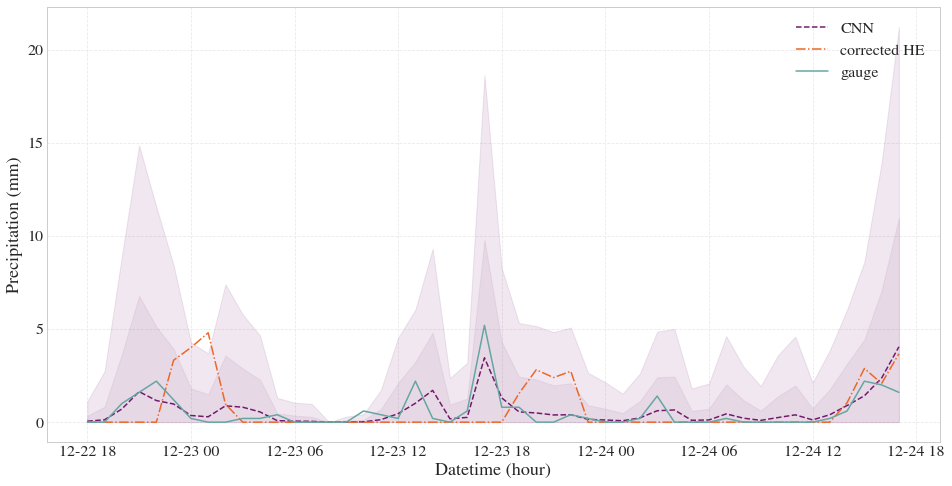

In [542]:
plotExample()

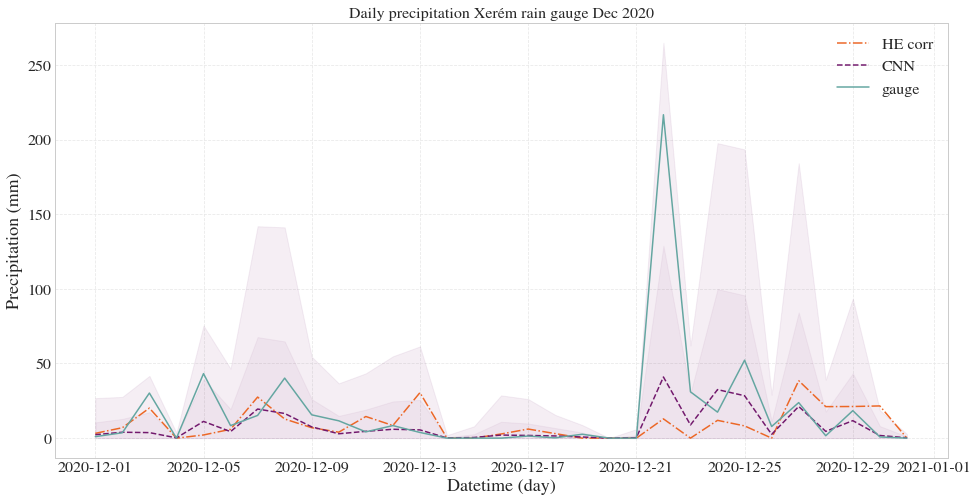

In [543]:

ind = 429
daym = combined.copy()
daym = daym.resample(time='D').sum()
fig, ax = plt.subplots(figsize=(16,8))
#plt.plot(daym.time, daym.mlp_posterior_mean[:, ind], label='mlp')
#ax.plot(daym.time, daym.HE_precip[:, ind], label='HE', color='#e6e6e6')
ax.fill_between(daym.time, daym['xception_Q0.99'][:, ind], alpha=0.07, color=color_cnn)
ax.fill_between(daym.time, daym['xception_Q0.95'][:, ind], alpha=0.05, color=color_cnn)

ax.plot(daym.time, daym.HE_precip_corr[:, ind], label='HE corr', linestyle='dashdot', color=color_HE_corr)
ax.plot(daym.time, daym.xception_posterior_mean[:, ind], label='CNN', linestyle='dashed', color=color_cnn)
ax.plot(daym.time, daym.gauge_precip[:, ind], label='gauge', color=color_gauges)

ax.grid(True,which="both",ls="--",c=color_grid)
ax.set_ylabel('Precipitation (mm)')
ax.set_xlabel('Datetime (day)')
ax.set_title('Daily precipitation Xerém rain gauge Dec 2020')
ax.legend()

### Scalar metrics

In [544]:
def Bias(a,b,dataset,mask):
    bias = np.mean(np.subtract(dataset[b].values, dataset[a].values)[mask==0])
    return(bias)

def MAE(a,b,dataset,mask):
    mae = np.mean(np.abs(np.subtract(dataset[b].values, dataset[a].values)[mask==0]))
    return(mae)

def MSE(a,b,dataset,mask):
    mse = np.mean(np.square(np.subtract(dataset[b].values, dataset[a].values)[mask==0]))
    return(mse)

#### Bias

In [545]:
print('HE:',Bias('gauge_precip','HE_precip',combined,mask))
print('HE corr:',Bias('gauge_precip','HE_precip_corr',combined,mask))
print('MLP:',Bias('gauge_precip','mlp_posterior_mean',combined,mask))
print('CNN:',Bias('gauge_precip','xception_posterior_mean',combined,mask))

HE: 0.1041845413295188
HE corr: -0.006546504557844834
MLP: -0.02128214204459453
CNN: 0.004233128358052377


#### MAE

In [546]:
print('HE:',MAE('gauge_precip','HE_precip',combined,mask))
print('HE corr:',MAE('gauge_precip','HE_precip_corr',combined,mask))
print('MLP:',MAE('gauge_precip','mlp_posterior_mean',combined,mask))
print('CNN:',MAE('gauge_precip','xception_posterior_mean',combined,mask))

HE: 0.39354618014600884
HE corr: 0.3000981773968421
MLP: 0.26460390683247
CNN: 0.23152983903431412


#### MSE

In [547]:
print('HE:',MSE('gauge_precip','HE_precip',combined,mask))
print('HE corr:',MSE('gauge_precip','HE_precip_corr',combined,mask))
print('MLP:',MSE('gauge_precip','mlp_posterior_mean',combined,mask))
print('CNN:',MSE('gauge_precip','xception_posterior_mean',combined,mask))

HE: 3.9399494848424386
HE corr: 2.4381287135261074
MLP: 2.03985636993056
CNN: 1.698436812975142


### Histograms 

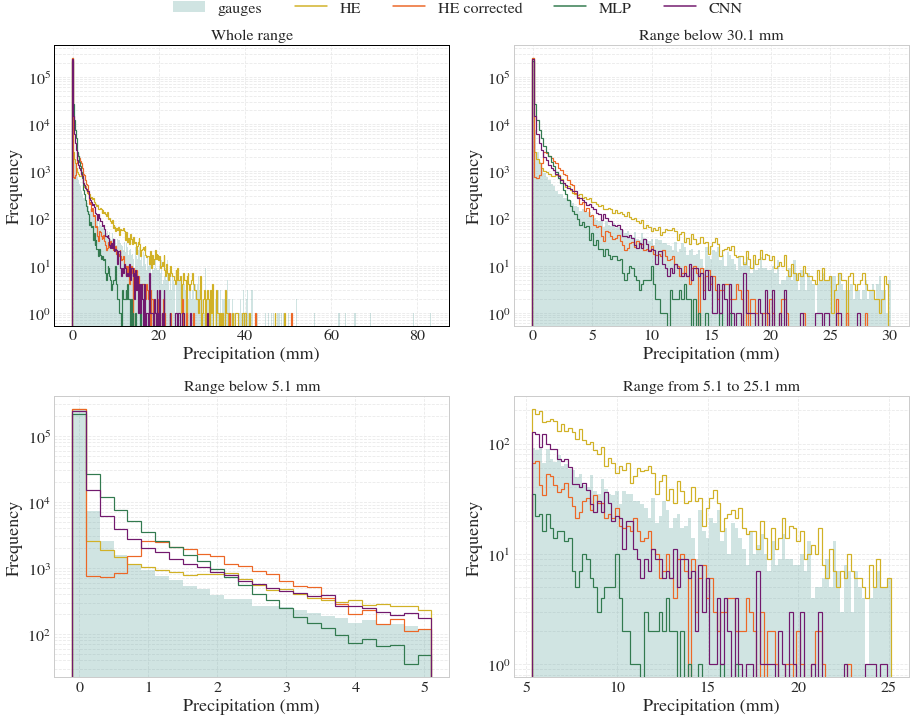

In [548]:
histtype='step'
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=figsize_four)

def rangeSuplotDists(dataset, bins, axnums=[0,0], title="Whole range"):

    ax[axnums[0],axnums[1]].hist(dataset.gauge_precip.values[mask==0].flatten(), histtype='bar', bins=bins, alpha=alpha_gauges_hist, label='gauges', color=color_gauges, linewidth=0.0, rasterized=True)

    var_list = ['HE_precip', 'HE_precip_corr', 'mlp_posterior_mean', 'xception_posterior_mean']
    label_list = ['HE', 'HE corrected', 'MLP', 'CNN']
    color_list = [color_HE, color_HE_corr, color_mlp, color_cnn]

    for i in range(len(var_list)):
        ax[axnums[0],axnums[1]].hist(dataset[var_list[i]].values[mask==0].flatten(), 
                                histtype=histtype, bins=bins, label=label_list[i], 
                                color=color_list[i], linewidth=1.2)

    ax[axnums[0],axnums[1]].set_yscale("log")
    ax[axnums[0],axnums[1]].grid(True,which="both",ls="--",c=color_grid)
    ax[axnums[0],axnums[1]].set_xlabel('Precipitation (mm)')
    ax[axnums[0],axnums[1]].set_ylabel('Frequency')
    ax[axnums[0],axnums[1]].set_title(title)

    
rangeSuplotDists(combined, bins, axnums=[0,0], title="Whole range")
subs2=152
rangeSuplotDists(combined, bins[:subs2], axnums=[0,1], title='Range below '+str(round(bins[subs2-1],1)) + ' mm')
subs2=27
rangeSuplotDists(combined, bins[:subs2], axnums=[1,0], title='Range below '+str(round(bins[subs2-1],1)) + ' mm')
subs1=27
subs2=127
rangeSuplotDists(combined, bins[subs1:subs2], axnums=[1,1], title='Range from ' + str(round(bins[subs1-1],1)) + ' to '+str(round(bins[subs2-1],1)) + ' mm')

plt.setp(ax[0,0].spines.values(), color='black')


handles, labels = ax[0,0].get_legend_handles_labels()
gauge_ind = labels.index('gauges')
labels.pop(gauge_ind)
gauges_handle = handles[gauge_ind]
handles.pop(gauge_ind)
new_handles = [Line2D([], [], c=h.get_edgecolor(),  linestyle=h.get_linestyle()) for h in handles]
labels = ['gauges'] + labels
new_handles = [gauges_handle] + new_handles

fig.legend(handles=new_handles, labels=labels, loc="upper center", ncol=5, borderaxespad=-0.30)
plt.tight_layout()


#plt.savefig('../plots/thesis/pdf_gauge.pdf', bbox_inches='tight')

### Diurnal cycle

In [549]:
import datetime
import timezonefinder, pytz

tf = timezonefinder.TimezoneFinder()

def getTimeZone(lat, lon):
    timezone_str = tf.certain_timezone_at(lat=lat, lng=lon)

    if timezone_str is None:
        print( "Could not determine the time zone")
        return(None)
    else:
        # Assuming same utc offset at given location throughout whole timeperiod Dec 2020
        timezone = pytz.timezone(timezone_str)
        dt = datetime.datetime(2020,12,1)
    return(timezone.utcoffset(dt).total_seconds()/3600.0)

In [550]:
def UTCtoLocal(dataset,mdat):
    shift = []
    for i in mdat.index:
        shift.append(getTimeZone(mdat.lat[i], mdat.lon[i]))
        
    ind_to_shift = []
    for s in np.unique(shift):
        ind_to_shift.append(list(np.where(shift==s)))
        
    di = dataset.copy()
    dj = dataset.copy()
    
    abs_diff = int(np.max(np.abs(np.unique(shift))))
    to_add = dj.time.min()+np.timedelta64(abs_diff,'h')
    
    dj = dj.where(dj.time<to_add, drop=True)
    dj = dj.where(dj.time<di.time.min())
    
    dj = dj.assign_coords(time=di.time[:abs_diff]-np.timedelta64(abs_diff,'h'))
    
    dext = xr.concat([dj, di], "time")
    
    datasets = []
    for i in range(len(np.unique(shift))):
        print(int(np.unique(shift)[i]))
        #print(ind_to_shift[i][0])
        selection = dext.copy().isel(location=ind_to_shift[i][0])
        selection = selection.shift(time=int(np.unique(shift)[i]))
        datasets.append(selection)    
        
    dshifted = xr.concat(datasets, "location")
    dshifted = dshifted.sortby("location")
    
    return(dshifted)

In [551]:
combined_local_time = UTCtoLocal(combined, metadata)

-5
-4
-3
-2


In [552]:
def diurnal_cycle(dataset, xlab='Time (hour)'):
    di = dataset.copy()
    di = di.mean(dim='location')
    di = di.groupby('time.hour')
    st = di.std()
    me = di.mean()

    fig, ax = plt.subplots(figsize=figsize_single_plot)

    ax.plot(me.hour, me.gauge_precip, label='gauges', color=color_gauges)
    ax.plot(me.hour, me.HE_precip_corr, label='HE corrected', linestyle='dashdot', color=color_HE_corr)
    ax.plot(me.hour, me.xception_posterior_mean, label='CNN', linestyle='dashed', color=color_cnn)
    ax.fill_between(me.hour, me.gauge_precip+st.gauge_precip,
                    me.gauge_precip-st.gauge_precip, linestyle='--', alpha=0.1, color=color_gauges)
    ax.fill_between(me.hour, me.HE_precip_corr+st.HE_precip_corr, 
                    me.HE_precip_corr-st.HE_precip_corr, alpha=0.1, color=color_HE_corr)
    ax.fill_between(me.hour, me.xception_posterior_mean+st.xception_posterior_mean,
                       me.xception_posterior_mean-st.xception_posterior_mean, alpha=0.1, color=color_cnn)
    ax.grid(True,which="both",ls="--",c=color_grid)
    ax.set_ylabel('Precipitation (mm)')
    ax.set_xlabel(xlab)
    ax.legend(loc='upper left')
    plt.tight_layout()
    #plt.savefig('../plots/thesis/diurnal_cycle_gauge.pdf', bbox_inches='tight')

In [553]:
#diurnal_cycle(combined)

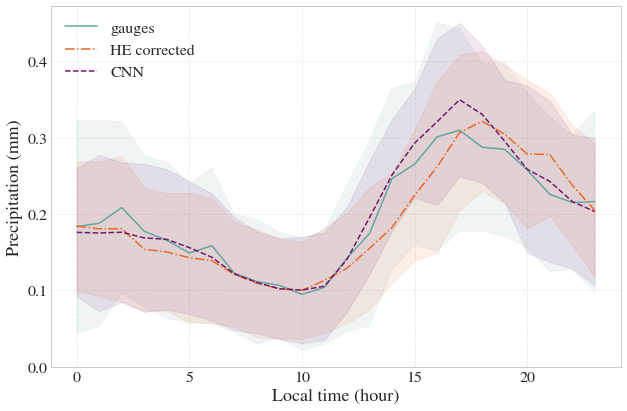

In [554]:
diurnal_cycle(combined_local_time, xlab='Local time (hour)') #time with local utc offset

### 2D histograms

-83.1
51.1
[-83.1 -83.  -82.9 ...  50.9  51.   51.1]
[-83.1 -83.  -82.9 ...  50.9  51.   51.1]


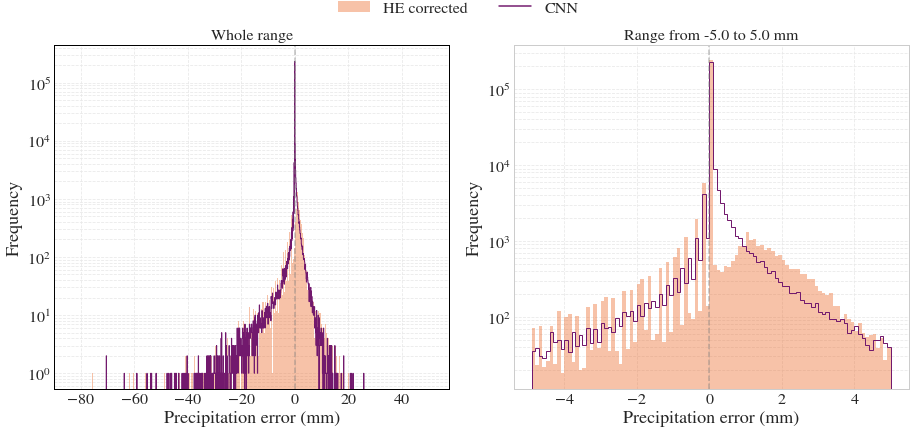

In [555]:
diff_HE_corr = np.subtract(combined['HE_precip_corr'].values, combined['gauge_precip'].values)[mask==0].flatten()
diff_CNN = np.subtract(combined['xception_posterior_mean'].values, combined['gauge_precip'].values)[mask==0].flatten()

start_diff = -83.1 #np.floor(np.min([np.min(diff_HE_corr), np.min(diff_CNN)]))
print(start_diff)
end_diff = 51.1 #np.ceil(np.max([np.max(diff_HE_corr), np.max(diff_CNN)]))
print(end_diff)
binsize_diff = 0.1
diffbins = np.linspace(start_diff,end_diff,int(np.round((end_diff-start_diff)/binsize_diff))+1)
print(diffbins)

fig, ax = plt.subplots(ncols=2, figsize=figsize_two_cols)

def plotDiffs(diffbins, axnum=0, title='Whole range'):
    ax[axnum].hist(diff_HE_corr, alpha=alpha_HE_corr_hist, bins=diffbins, color=color_HE_corr, label='HE corrected', linewidth=0.0, rasterized=True)
    ax[axnum].hist(diff_CNN, bins=diffbins, color=color_cnn, label='CNN', histtype='step')
    ax[axnum].set_ylabel('Frequency')
    ax[axnum].set_xlabel('Precipitation error (mm)')
    ax[axnum].set_yscale("log")
    ax[axnum].axvline(x=0.0, color='grey', alpha=0.5, linestyle='dashed')
    ax[axnum].grid(True,which="both",ls="--",c=color_grid)
    ax[axnum].set_title(title)
    
plotDiffs(diffbins, axnum=0, title='Whole range')
subs1=782#732
subs2=882#932
print(diffbins)
plotDiffs(diffbins[subs1:subs2], axnum=1, title='Range from ' + str(round(diffbins[subs1-1],1)) + ' to '+str(round(diffbins[subs2-1],1)) + ' mm')

plt.setp(ax[0].spines.values(), color='black')

handles, labels = ax[0].get_legend_handles_labels()
hist_lab_ind = labels.index('HE corrected')
labels.pop(hist_lab_ind)
hist_lab_handle = handles[hist_lab_ind]
handles.pop(hist_lab_ind)
new_handles = [Line2D([], [], c=h.get_edgecolor(),  linestyle=h.get_linestyle()) for h in handles]
labels = ['HE corrected'] + labels
new_handles = [hist_lab_handle] + new_handles

             
fig.legend(handles=new_handles, labels=labels, loc="upper center", ncol=2, borderaxespad=-0.30)
plt.tight_layout()
#plt.savefig('../plots/thesis/diff_gauge.pdf', bbox_inches='tight')

In [556]:
#cmap
big = cm.get_cmap('magma', 512)
newcmp = ListedColormap(big(np.linspace(0.1, 0.9, 256)))


In [557]:
def hist2D(dataset, varnames, labelnames, norm_type=None):
    fig, ax = plt.subplots(ncols=len(varnames), figsize=figsize_two_cols)
    
    y_true = dataset.gauge_precip.values[mask==0].flatten()
    bins = np.logspace(-1, 2, 51)
    
    old_vmax = 0
    freqs_list = []
    for i in range(len(varnames)):
        y_pred = dataset[varnames[i]].values[mask==0].flatten()

        freqs, _, _ = np.histogram2d(y_true, y_pred, bins=bins)
        freqs[freqs==0.0] = np.nan
        extend = 'neither'


        if norm_type==None:
            freqs_normed = freqs
            colorbar_label = 'Frequency'
            vmax = np.max([old_vmax,np.nanmax(freqs)])
            old_vmax = vmax
        elif norm_type=='colwise':
            freqs_normed = freqs
            colorbar_label = 'Frequency, normalized columnwise'
            for col_ind in range(freqs.shape[0]):
                if np.isnan(freqs[col_ind, :]).all():
                    freqs_normed[col_ind, :] = np.array([np.nan] * freqs.shape[1])
                else:
                    freqs_normed[col_ind, :] = freqs[col_ind, :] / np.nansum(freqs[col_ind, :])
            vmax=np.max([old_vmax, np.percentile(freqs_normed[np.isnan(freqs_normed)==False], 95)])
            old_vmax = vmax
            extend = 'max'
            print(vmax)     
        
        freqs_list.append(freqs_normed)
            
    for i in range(len(varnames)):
        freqs_normed = freqs_list[i]
        m = ax[i].pcolormesh(bins, bins, freqs_normed.T, cmap=newcmp, vmax=vmax,
                          linewidth=0.0, rasterized=True)
        
        ax[i].set_xlim([1e-1, 1e2])
        ax[i].set_ylim([1e-1, 1e2])
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")
        ax[i].set_xlabel("Reference precipitation (mm)")
        ax[i].set_ylabel("Predicted precipitation (mm)")
        ax[i].plot(bins, bins, c="grey", ls="--")
        ax[i].grid(True,which="both",ls="--",c=color_grid)
        ax[i].set_aspect('equal')
        ax[i].set_title(labelnames[i])
    #divider = make_axes_locatable(ax[axnums[0], axnums[1]])
    #cax = divider.append_axes("right", size="5%", pad=0.07)
    #plt.colorbar(m, cax=cax, extend=extend, label=colorbar_label)
    fig.subplots_adjust(wspace=0.3)
    fig.colorbar(m, ax=ax, fraction=0.022, pad=0.023, extend=extend).set_label(label=colorbar_label, size=18)
    #fig.tight_layout(w_pad=20.0)
    #fig.colorbar(m, ax=ax.ravel().tolist())
    #plt.tight_layout()


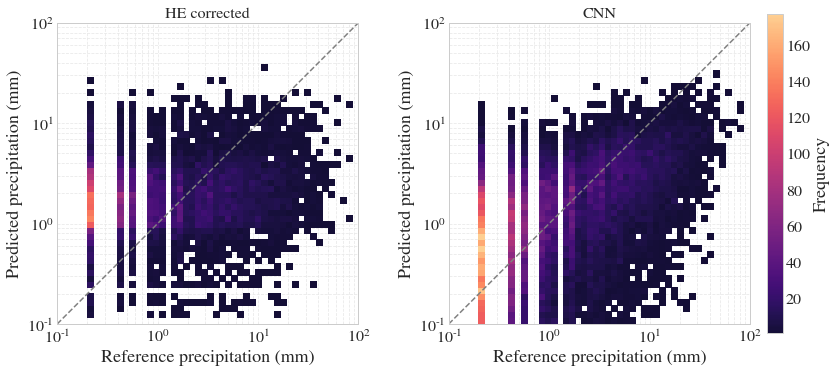

In [558]:
hist2D(combined, ['HE_precip_corr', 'xception_posterior_mean'], ['HE corrected', 'CNN'], norm_type=None)

0.10032880451640916
0.10032880451640916


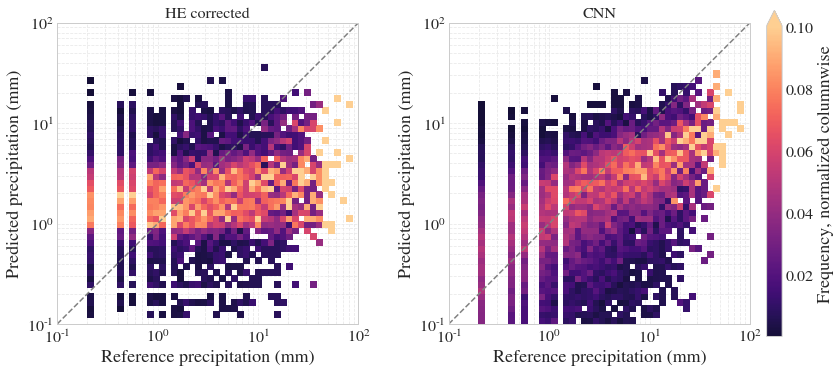

In [559]:
hist2D(combined, ['HE_precip_corr', 'xception_posterior_mean'], ['HE corrected', 'CNN'], norm_type='colwise')

In [560]:
def Classification(y,p, threshold=1e-1):

    TP = (p[y>threshold]>threshold).sum() #Is rain, predict rain
    TN = (p[y<=threshold]<=threshold).sum() #Is no rain, predict no rain
    FP = (p[y<=threshold]>threshold).sum() #Is no rain, predict rain
    FN = (p[y>threshold]<=threshold).sum() #Is rain, predict no rain

    fig, ax = plt.subplots()
    confusion_matrix = np.array([[FP, TP], [TN, FN]])#np.array([[TP, FN], [FP, TN]])
    m = ax.imshow(confusion_matrix, cmap='Greens')
    ax.set_ylabel('Predicted class')
    ax.set_xlabel('True class')
    ax.grid(False)
    ax.set_xticks(ticks=[0,1])
    ax.set_xticklabels(labels=['No rain', 'Rain',])
    ax.set_yticks(ticks=[1,0])
    ax.set_yticklabels(labels=['No rain', 'Rain'])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    plt.colorbar(m, cax=cax)
    
    # Loop over data dimensions and create text annotations.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            text = ax.text(j, i, confusion_matrix[i, j],
                           ha="center", va="center", color="orange", fontsize=18)
    plt.show()
    
    print('TP, Is rain, predict rain:', TP)
    print('TN, Is no rain, predict no rain:', TN)
    print('FP, Is no rain, predict rain:', FP)
    print('FN, Is rain, predict no rain:', FN)

    TPR = (TP/(TP+FN)) #Sensitivity or Recall (POD=hits/(hits+misses))
    print('TPR', "{:.2f}".format(TPR))
    TNR = (TN/(TN+FP)) #Specificity
    #print('TPR', "{:.2f}".format(TNR))
    PPV = (TP/(TP+FP)) #Precision
    #print('PPV', "{:.2f}".format(PPV))
    PNV = (TN/(TN+FN))
    #print('PNV', "{:.2f}".format(PNV))

    FAR = (FP/(FP+FN)) #false alarms/(false alarms+hits)
    print('FAR', "{:.2f}".format(FAR)) 

    CSI = TP/(TP+FN+FP) #hits/(hits+misses+false alarms)
    print('CSI', "{:.2f}".format(CSI))
    
    FPR = FP/(FP+TN)
    FNR = FN/(FN+TP)
    print('FPR:', FPR)
    print('FNR:', FNR)

In [561]:
bins

array([-0.1,  0.1,  0.3,  0.5,  0.7,  0.9,  1.1,  1.3,  1.5,  1.7,  1.9,
        2.1,  2.3,  2.5,  2.7,  2.9,  3.1,  3.3,  3.5,  3.7,  3.9,  4.1,
        4.3,  4.5,  4.7,  4.9,  5.1,  5.3,  5.5,  5.7,  5.9,  6.1,  6.3,
        6.5,  6.7,  6.9,  7.1,  7.3,  7.5,  7.7,  7.9,  8.1,  8.3,  8.5,
        8.7,  8.9,  9.1,  9.3,  9.5,  9.7,  9.9, 10.1, 10.3, 10.5, 10.7,
       10.9, 11.1, 11.3, 11.5, 11.7, 11.9, 12.1, 12.3, 12.5, 12.7, 12.9,
       13.1, 13.3, 13.5, 13.7, 13.9, 14.1, 14.3, 14.5, 14.7, 14.9, 15.1,
       15.3, 15.5, 15.7, 15.9, 16.1, 16.3, 16.5, 16.7, 16.9, 17.1, 17.3,
       17.5, 17.7, 17.9, 18.1, 18.3, 18.5, 18.7, 18.9, 19.1, 19.3, 19.5,
       19.7, 19.9, 20.1, 20.3, 20.5, 20.7, 20.9, 21.1, 21.3, 21.5, 21.7,
       21.9, 22.1, 22.3, 22.5, 22.7, 22.9, 23.1, 23.3, 23.5, 23.7, 23.9,
       24.1, 24.3, 24.5, 24.7, 24.9, 25.1, 25.3, 25.5, 25.7, 25.9, 26.1,
       26.3, 26.5, 26.7, 26.9, 27.1, 27.3, 27.5, 27.7, 27.9, 28.1, 28.3,
       28.5, 28.7, 28.9, 29.1, 29.3, 29.5, 29.7, 29

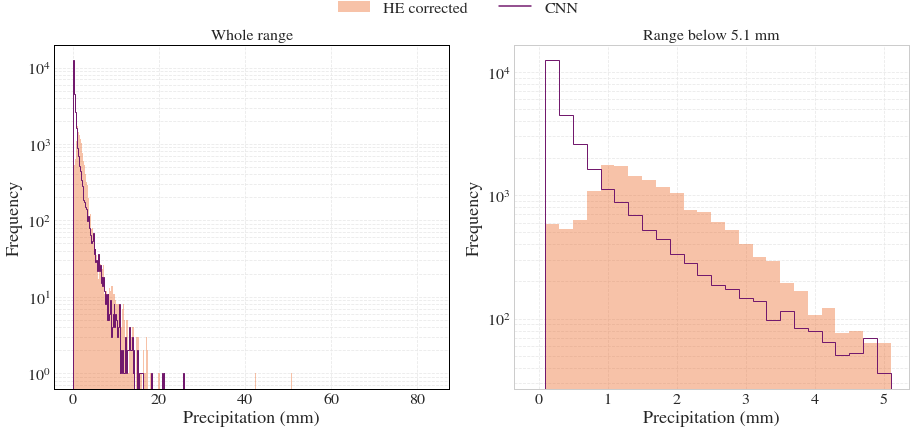

In [562]:
threshold = 1e-1
y = combined.gauge_precip.values[mask==0].flatten()
p = combined.xception_posterior_mean.values[mask==0].flatten()
r = combined.HE_precip_corr.values[mask==0].flatten()


fig, ax = plt.subplots(ncols=2,figsize=figsize_two_cols)

def FalsePositivesPlot(y,p,r,bins, axnum=0, title="Whole range"):
    pp = p[y<=threshold]
    rr = r[y<=threshold]
    ax[axnum].hist(pp[pp>threshold], bins=bins, color=color_cnn, histtype='step', label='CNN')
    ax[axnum].hist(rr[rr>threshold], bins=bins, alpha=alpha_HE_corr_hist, color=color_HE_corr,  label='HE corrected', linewidth=0.0, rasterized=True)
    ax[axnum].set_yscale("log")
    ax[axnum].grid(True,which="both",ls="--",c=color_grid) 
    #ax.set_ylim([5e-1, 1e4])
    ax[axnum].set_ylabel('Frequency')
    ax[axnum].set_xlabel('Precipitation (mm)')
    ax[axnum].set_title(title)
    #ax.s_title('Distribution of non-zero predicted rain corresponding to no rain reference values')
    
FalsePositivesPlot(y,p,r, bins, axnum=0)
subs1=27
FalsePositivesPlot(y,p,r, bins[:subs1], axnum=1, title='Range below ' +str(round(bins[subs1-1],1)) + ' mm')
    
plt.setp(ax[0].spines.values(), color='black')
    
handles, labels = ax[0].get_legend_handles_labels()
hist_lab_ind = labels.index('HE corrected')
labels.pop(hist_lab_ind)
hist_lab_handle = handles[hist_lab_ind]
handles.pop(hist_lab_ind)
new_handles = [Line2D([], [], c=h.get_edgecolor(),  linestyle=h.get_linestyle()) for h in handles]
labels = ['HE corrected'] + labels
new_handles = [hist_lab_handle] + new_handles


fig.legend(handles=new_handles, labels=labels, loc="upper center", ncol=2, borderaxespad=-0.30)
plt.tight_layout()

#plt.savefig('../plots/thesis/FalsePositives_gauge.pdf', bbox_inches='tight')




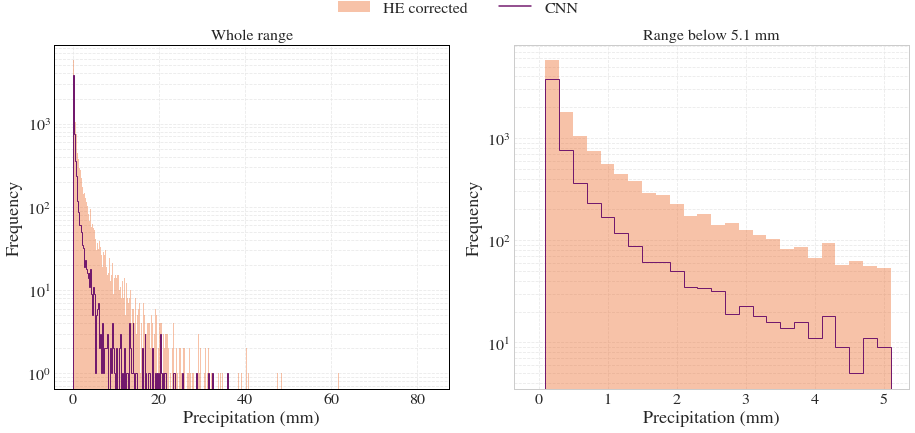

In [569]:
threshold = 1e-1
y = combined.gauge_precip.values[mask==0].flatten()
p = combined.xception_posterior_mean.values[mask==0].flatten()
r = combined.HE_precip_corr.values[mask==0].flatten()


fig, ax = plt.subplots(ncols=2,figsize=figsize_two_cols)

def FalseNegativesPlot(y,p,r,bins, axnum=0, title="Whole range"):
    yp = y[p<=threshold]
    yr = y[r<=threshold]
    ax[axnum].hist(yp[yp>threshold], bins=bins, color=color_cnn, histtype='step', label='CNN')
    ax[axnum].hist(yr[yr>threshold], bins=bins, alpha=alpha_HE_corr_hist, color=color_HE_corr, label='HE corrected', linewidth=0.0, rasterized=True)
    ax[axnum].set_yscale("log")
    ax[axnum].grid(True,which="both",ls="--",c=color_grid) 
    #ax.set_ylim([5e-1, 1e4])
    ax[axnum].set_ylabel('Frequency')
    ax[axnum].set_xlabel('Precipitation (mm)')
    #ax.set_title('Distribution of non-zero reference values corresponding to no rain predictions')
    ax[axnum].set_title(title)
    
FalseNegativesPlot(y,p,r, bins, axnum=0)
subs1=27
FalseNegativesPlot(y,p,r, bins[:subs1], axnum=1, title='Range below ' +str(round(bins[subs1-1],1)) + ' mm')
    
plt.setp(ax[0].spines.values(), color='black')
    
handles, labels = ax[0].get_legend_handles_labels()
hist_lab_ind = labels.index('HE corrected')
labels.pop(hist_lab_ind)
hist_lab_handle = handles[hist_lab_ind]
handles.pop(hist_lab_ind)
new_handles = [Line2D([], [], c=h.get_edgecolor(),  linestyle=h.get_linestyle()) for h in handles]
labels = ['HE corrected'] + labels
new_handles = [hist_lab_handle] + new_handles


fig.legend(handles=new_handles, labels=labels, loc="upper center", ncol=2, borderaxespad=-0.30)
plt.tight_layout()

#plt.savefig('../plots/thesis/FalseNegatives_gauge.pdf', bbox_inches='tight')




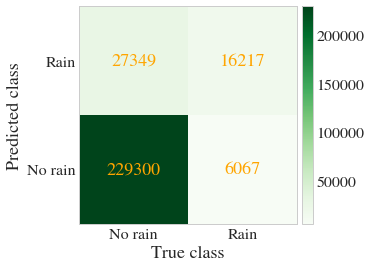

TP, Is rain, predict rain: 16217
TN, Is no rain, predict no rain: 229300
FP, Is no rain, predict rain: 27349
FN, Is rain, predict no rain: 6067
TPR 0.73
FAR 0.82
CSI 0.33
FPR: 0.10656188023331475
FNR: 0.2722581224196733


In [564]:
Classification(combined.gauge_precip.values[mask==0].flatten(),
               combined.xception_posterior_mean.values[mask==0].flatten())

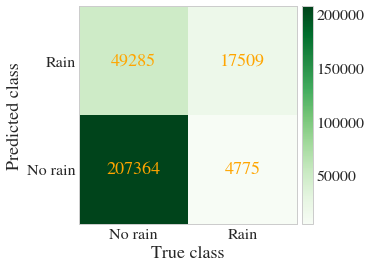

TP, Is rain, predict rain: 17509
TN, Is no rain, predict no rain: 207364
FP, Is no rain, predict rain: 49285
FN, Is rain, predict no rain: 4775
TPR 0.79
FAR 0.91
CSI 0.24
FPR: 0.19203269835456208
FNR: 0.21427930353616945


In [565]:
Classification(combined.gauge_precip.values[mask==0].flatten(),
               combined.mlp_posterior_mean.values[mask==0].flatten())

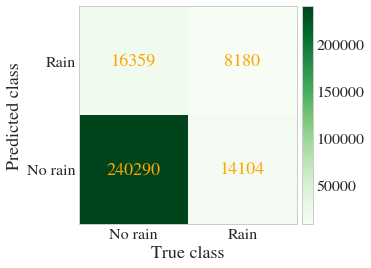

TP, Is rain, predict rain: 8180
TN, Is no rain, predict no rain: 240290
FP, Is no rain, predict rain: 16359
FN, Is rain, predict no rain: 14104
TPR 0.37
FAR 0.54
CSI 0.21
FPR: 0.06374075098675623
FNR: 0.6329204810626459


In [566]:
Classification(combined.gauge_precip.values[mask==0].flatten(),
               combined.HE_precip_corr.values[mask==0].flatten())

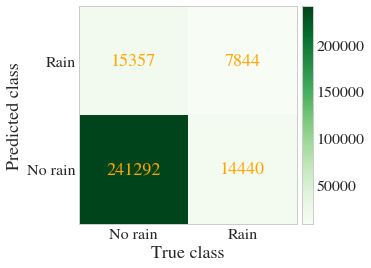

TP, Is rain, predict rain: 7844
TN, Is no rain, predict no rain: 241292
FP, Is no rain, predict rain: 15357
FN, Is rain, predict no rain: 14440
TPR 0.35
FAR 0.52
CSI 0.21
FPR: 0.05983658615463142
FNR: 0.647998563992102


In [567]:
Classification(combined.gauge_precip.values[mask==0].flatten(),
               combined.HE_precip.values[mask==0].flatten())

### By region

['N', 'SE', 'CW', 'S', 'NE']
100
149
115
95
150


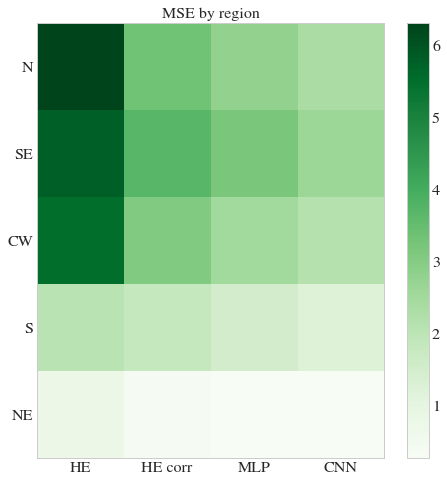

In [568]:
reg = ['N', 'SE', 'CW', 'S', 'NE'] #np.unique(metadata.region)
print(reg)
mse_by_region = np.zeros((len(reg),4))

for i in range(len(reg)):
    locs = list(metadata.index[metadata.region == reg[i]])
    print(len(locs))
    selection = combined.copy().isel(location=locs)
    mse_by_region[i,0] = MSE('gauge_precip', 'HE_precip', selection, mask[:,locs])
    mse_by_region[i,1] = MSE('gauge_precip', 'HE_precip_corr', selection, mask[:,locs])
    mse_by_region[i,2] = MSE('gauge_precip', 'mlp_posterior_mean', selection, mask[:,locs])
    mse_by_region[i,3] = MSE('gauge_precip', 'xception_posterior_mean', selection, mask[:,locs])
    
fig, ax = plt.subplots(figsize=(8,8))
m = ax.imshow(mse_by_region, cmap='Greens')
ax.set_yticks(list(range(len(reg))))
ax.set_yticklabels(reg)
mods = ['HE', 'HE corr', 'MLP', 'CNN']
ax.set_xticks(list(range(len(mods))))
ax.set_xticklabels(mods)
ax.set_title('MSE by region')
ax.grid(False)
fig.colorbar(m)
plt.show()